In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df
from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves 
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [42]:
datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']

#ARGS for paris
SPECIE = 'human'

#ARGS for splash, ricseq, mario
only_test = False
exclude_train_genes = False
exclude_paris_genes = False
exclude_paris_couples = True
filter_hq_ricseq = False
MIN_N_READS_RICSEQ = 3

In [43]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0061parisHQSPLASHval0098') 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

In [87]:
def load_res_and_tools(checkpoint_dir, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ):

    if dataset == 'paris':
        test500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        assert test500.shape[0] == df_nt[['couples', 'interacting']].merge(test500, on = 'couples').shape[0]
        test500 = df_nt[['couples', 'interacting', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex']].merge(test500, on = 'couples')
        id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)
        res = load_paris_results(checkpoint_dir, test500, 'test', SPECIE)
    else:
        test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
        res = load_ricseq_splash_mario_results(checkpoint_dir, test500, df_nt, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)

    res = res.drop_duplicates('id_sample').reset_index(drop = True)
    assert res.shape[0] == len(res.id_sample.unique())
    
    for tool_name in tools:
        tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
        tool['value'] = tool['value'].astype(float)
        assert (tool.minimum == True).all()
        res = res.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample')
    res = res.drop_duplicates('id_sample').reset_index(drop = True)
    assert res.shape[0] == len(res.id_sample.unique())
    
    return res


def plot_all_model_auc(subset, tools):
    
    result_list = []

    result_list.append({'prob': subset.probability, 'model_name': 'NT'})
    result_list.append({'prob': abs(subset.E_norm), 'model_name': 'Intarna'})

    for tool_name in tools:
        result_list.append({'prob': abs(subset[tool_name]), 'model_name': tool_name})

    plot_roc_curves(result_list, subset.ground_truth)
    
    
def obtain_all_model_auc(subset, tools):
    
    aucs=[]
    names = []
    
    fpr, tpr, _ = roc_curve(subset.ground_truth, subset['probability'])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    names.append('NT')
    
    fpr, tpr, _ = roc_curve(subset.ground_truth, abs(subset['E_norm']))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    names.append('INTARNA')
    
    for tool_name in tools:
        
        fpr, tpr, _ = roc_curve(subset.ground_truth, abs(subset[tool_name]))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        names.append(tool_name)
        
    df_out= pd.DataFrame({'model_name':names, 'auc':aucs})
    df_out['auc'] = df_out['auc'].round(2)
    return df_out


DATASET: paris


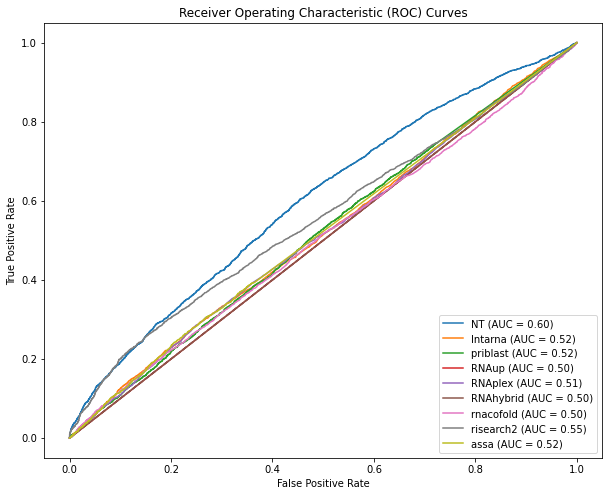

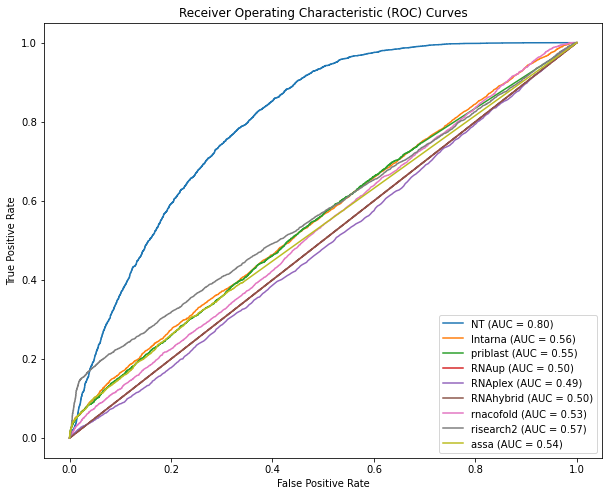




# excluded couples:  234
DATASET: ricseq


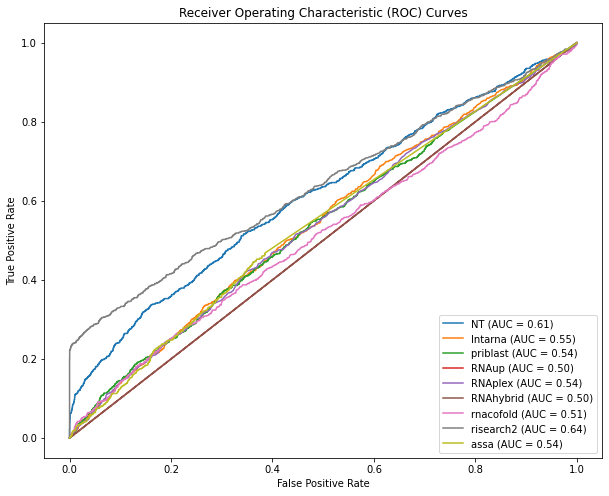

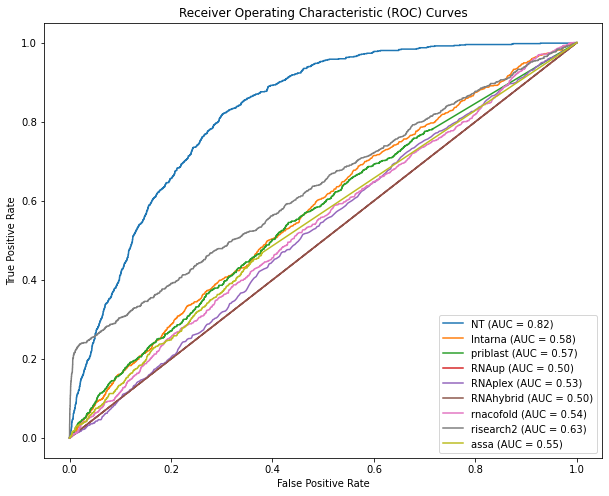




# excluded couples:  56
DATASET: splash


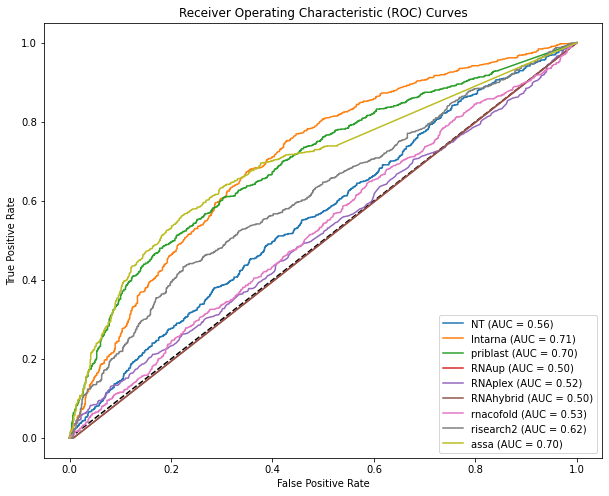

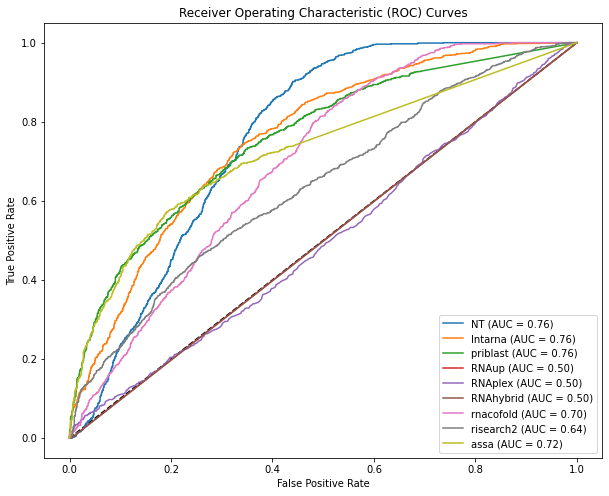




# excluded couples:  4
DATASET: mario


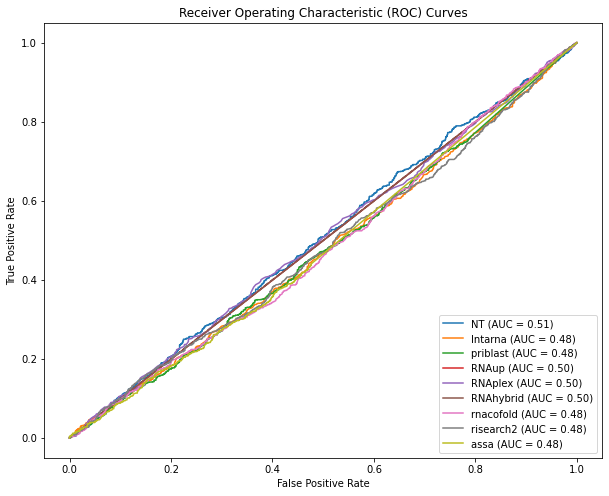

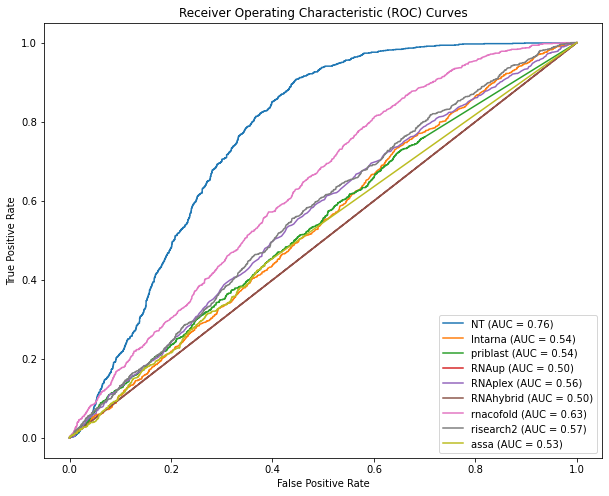

In [88]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(checkpoint_dir, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))
    
    print(f'DATASET: {dataset}')
    plot_all_model_auc(easypos_smartneg, tools)
    plot_all_model_auc(ephnen, tools)
    print('\n\n')

In [89]:
df=pd.concat(dfs, axis = 1)
df = df.loc[:,~df.columns.duplicated()].copy()

ricseq


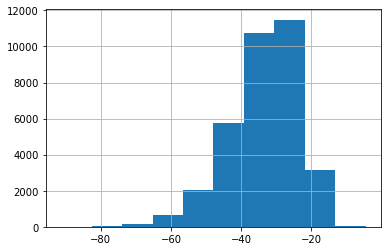



mario


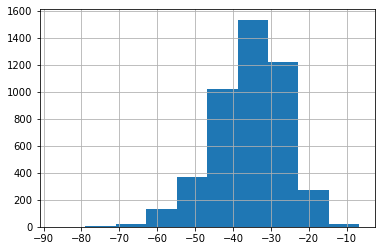



test


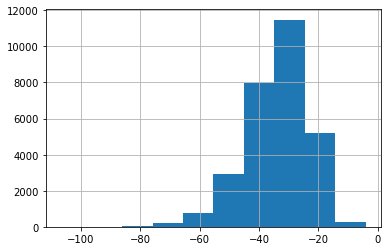



splash


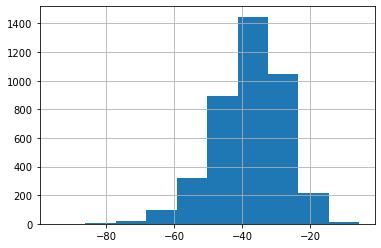

In [131]:
tool_name = 'RNAplex'
for how in ['ricseq', 'mario', 'test', 'splash']:
    tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
    tool['value'] = tool['value'].astype(float)
    print(how)
    tool.value.hist()
    plt.show()
    print('\n')

# TODO: FAI QUESTI PLOT QUI SOTTO

Text(0.5, 0, 'Perc%')

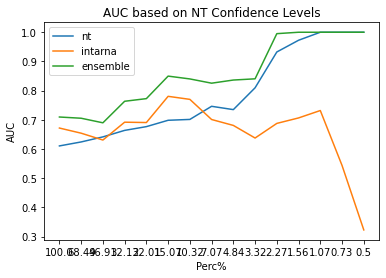

In [27]:
n_values = 15
MIN_PERC = 0.5

confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

Text(0.5, 0, 'Perc%')

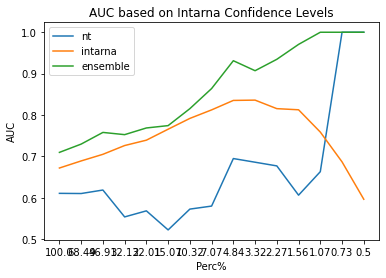

In [28]:
confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

Text(0.5, 0, 'Perc%')

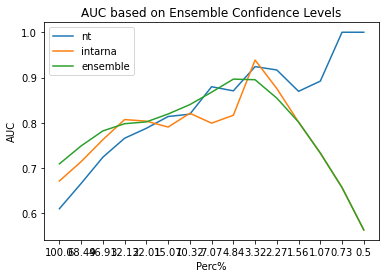

In [29]:
confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(easypos_smartneg, how = 'ensemble', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title('AUC based on Ensemble Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")